# Seismic phase determination

Let's look at [seismic phase determination](https://www.subsurfwiki.org/wiki/Phase_determination). 

The must-read papers on this topic:

- Roden, R and H Sepulveda (1999). The significance of phase to the interpreter; practical guidelines for phase analysis. _The Leading Edge_ **18** (7), p. 774–777.
- Perz, M, M Sacchi and A O'Byrne (2004). Instantaneous phase and the detection of lateral wavelet stability. _The Leading Edge_ **23** (7), 639–643.
- Purves, S (2014), Phase and the Hilbert transform. _The Leading Edge_ **33**, 1164, 1166. https://doi.org/10.1190/tle33101164.1
- White, R (1988). Maximum kurtosis phase correction. https://academic.oup.com/gji/article/95/2/371/728307

We'll also need some horizons, so this notebook contains some stuff on making and slicing with horizons.

In [11]:
import numpy as np
import matplotlib.pyplot as plt

## Load some seismic with `segyio`

In [12]:
import segyio

with segyio.open('../data/Penobscot_xl1155.sgy') as s:
    seismic, = segyio.cube(s)

And we can define semi-real-world cordinates of the seismic data using `extent=(0, 400, 4.0, 0)` in `imshow()`.

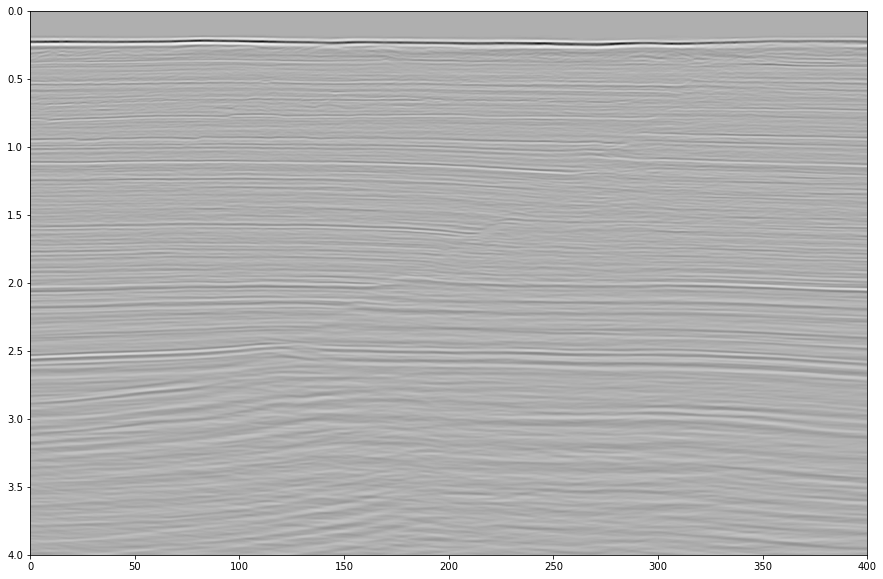

In [13]:
plt.figure(figsize=(15, 10))
plt.imshow(seismic.T, cmap='Greys', extent=(0, 400, 4.0, 0), aspect='auto')
plt.show()

## Get sea-floor pick

### EXERCISE

Can you think of a quick way to auto-pick the sea-floor? <a title="np.argmax() could be useful."><b>Hover for HINT</b></a> 

Plot it on the seismic section.

In [14]:
# Naive method, use argmax
sf_idx_naive = np.argmax(seismic.T[:80], axis=0)
sf_naive = sf_idx_naive * 0.0040

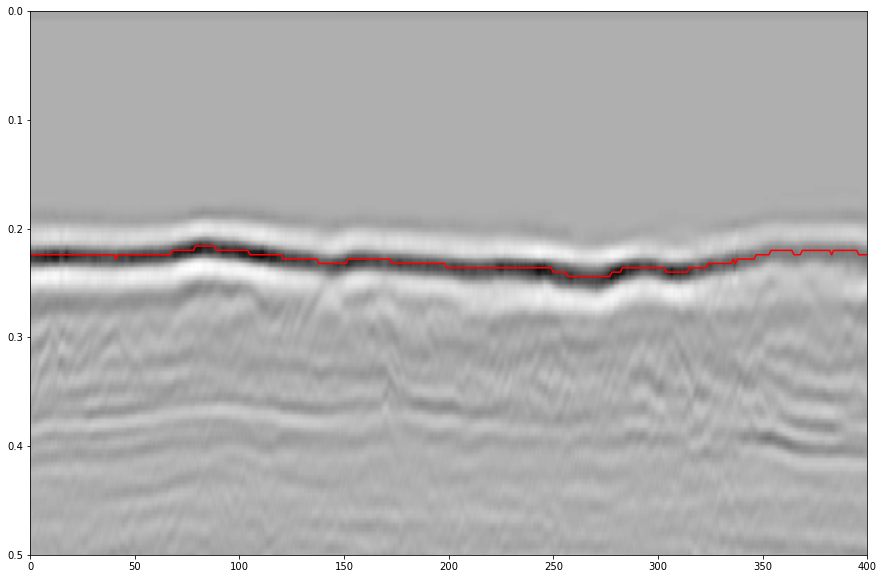

In [15]:
plt.figure(figsize=(15, 10))
plt.imshow(seismic.T, cmap='Greys', extent=(0, 400, 4.0, 0), aspect='auto')
plt.plot(sf_naive, 'r')
plt.ylim(0.5, 0)
plt.show()

Notice that the result is discrete — it can only take index values, i.e. integer multiples of 4 ms.

You could smooth it, but it's probably better to try to pick the position of the actual peak, given a continuous trace. A fast way to do this is to assume a parabolic shape, which then has an analytic solution for a zero derivative.

In [16]:
# Better: use parabolic interpolation.
def parabolic(f, x):
    """
    Parabolic interpolation finds the approximate position and value
    of the local maximum on a curve, given the position of the closest
    peak, eg with argmax().
    """
    xv = 1/2. * (f[x-1] - f[x+1]) / (f[x-1] - 2 * f[x] + f[x+1]) + x
    yv = f[x] - (1/4) * (f[x-1] - f[x+1]) * (xv - x)
    return (xv, yv)

def get_max_time(trace):
    t_max, a_max = parabolic(trace, np.argmax(trace))
    return t_max

sf_idx = np.apply_along_axis(get_max_time, axis=1, arr=seismic[:, :80])
sf = sf_idx * 0.0040

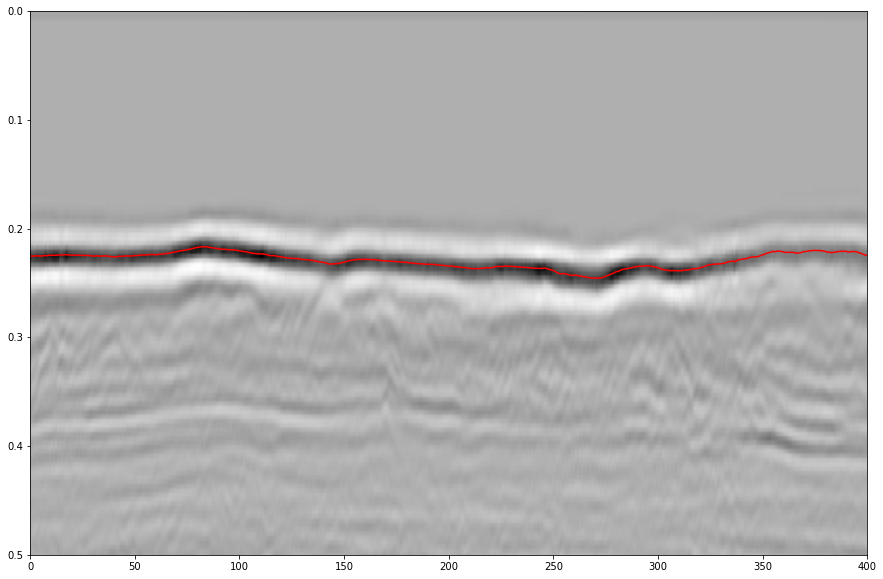

In [19]:
plt.figure(figsize=(15, 10))
plt.imshow(seismic.T, cmap='Greys', extent=(0, 400, 4.0, 0), aspect='auto')
plt.plot(sf, 'r')
plt.ylim(0.5, 0)
plt.show()

### EXERCISE

Extract the amplitude from the seismic onto the horizon, and plot that in a new matplotlib axes (aka subplot), above the seismic section.

In [20]:
# YOUR CODE HERE



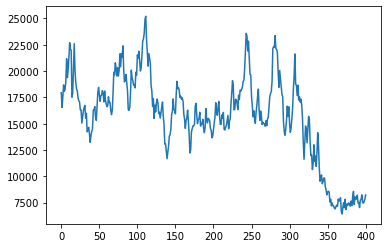

In [174]:
# Tempting to try:
#   amp = seismic[:, sf_idx]

# But you need to tell NumPy which to take from each axis:
amp = seismic[np.arange(401), sf_idx_naive]  # Or use int(sf)

plt.plot(amp)

In [175]:
# Or we can get it from the parabolic interpolation function:
def get_max_amp(trace):
    t_max, a_max = parabolic(trace, np.argmax(trace))
    return a_max

amp_interpolated = np.apply_along_axis(get_max_amp, axis=1, arr=seismic[:, :80])

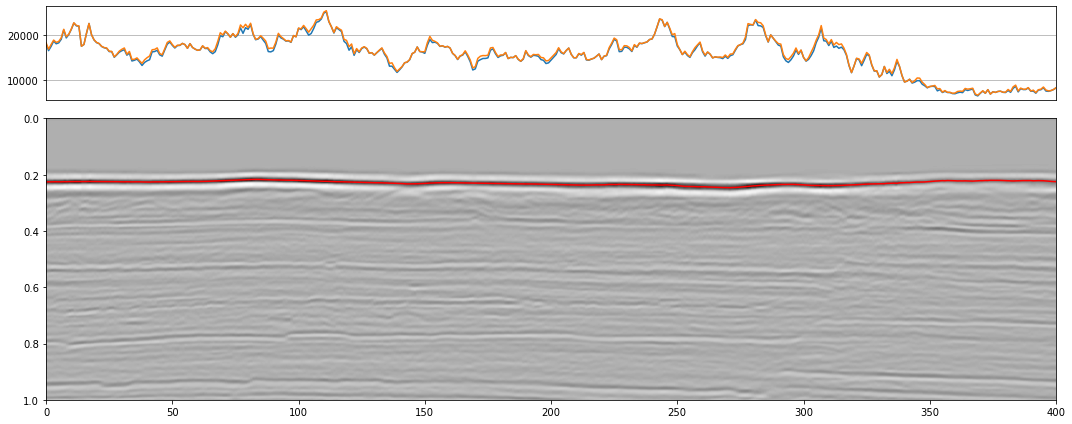

In [176]:
fig, axs = plt.subplots(nrows=2, figsize=(15, 6), gridspec_kw={'height_ratios': [1, 3]})
axs[0].plot(amp)
axs[0].plot(amp_interpolated) # Orange.
axs[0].set_xlim(0, 400)
axs[0].set_xticks([])
axs[0].grid()
axs[1].imshow(seismic.T, cmap='Greys', extent=(0, 400, 4.0, 0), aspect='auto')
axs[1].set_ylim(1, 0)
axs[1].plot(sf, 'r')
plt.tight_layout()
plt.show()

## `xarray`

Another option is to use `xarray`.

### EXERCISE

Make a `DataArray` for the seismic volume. Call it `seismic_`.

Try making one for the horizon too. Call it `sf_`.

In [177]:
import xarray as xr

i, t = map(np.arange, seismic.shape)

seismic_ = xr.DataArray(seismic,
                        name='amplitude',
                        coords=[i, t*0.004],
                        dims=['inline', 'twt']
                       )

sf_ = xr.DataArray(sf,
                   name='twt',
                   coords=[i],
                   dims=['inline'],
                  )

In [178]:
seismic_

<xarray.DataArray 'amplitude' (inline: 401, twt: 1003)>
array([[1100., 1155.,    0., ..., 1113., 1108., 1068.],
       [1101., 1155.,    0., ..., 1227., 1162.,  981.],
       [1102., 1155.,    0., ..., 1276., 1135., 1008.],
       ...,
       [1498., 1155.,    0., ...,  685.,  459., -246.],
       [1499., 1155.,    0., ...,  735.,  478., -233.],
       [1500., 1155.,    0., ...,  731.,  465., -289.]], dtype=float32)
Coordinates:
  * inline   (inline) int64 0 1 2 3 4 5 6 7 ... 393 394 395 396 397 398 399 400
  * twt      (twt) float64 0.0 0.004 0.008 0.012 0.016 ... 3.996 4.0 4.004 4.008

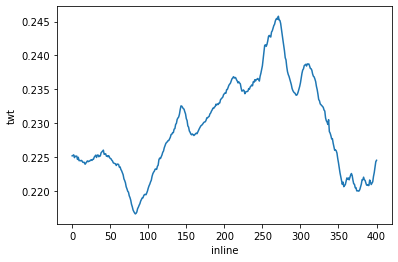

In [179]:
sf_.plot()

Now we can easily slice into the seismic volume using the horizon. We get linear interpolation for free!

In [180]:
amp_ = seismic_.interp(inline=sf_.inline, twt=sf_, method='linear')

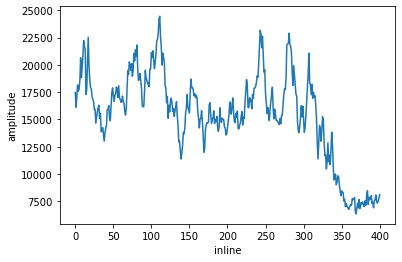

In [181]:
amp_.plot()

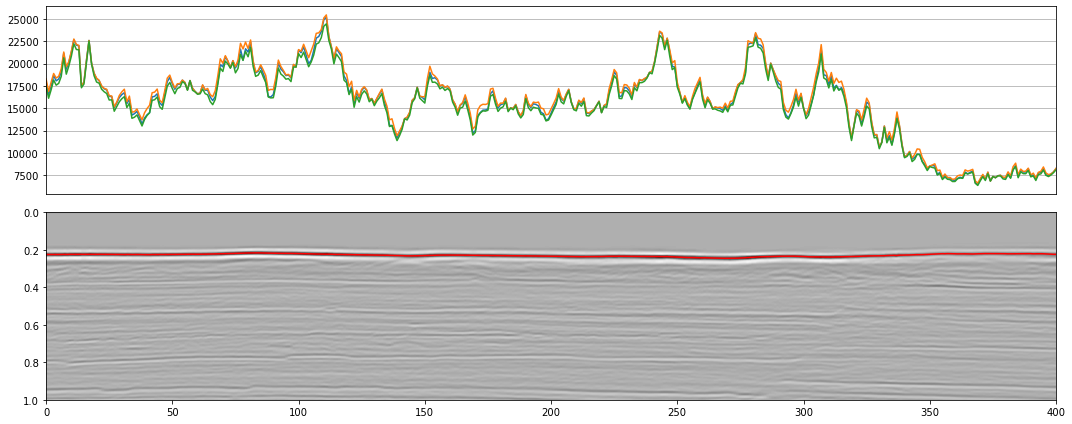

In [182]:
fig, axs = plt.subplots(nrows=2, figsize=(15, 6), gridspec_kw={'height_ratios': [1, 1]})

axs[0].plot(amp)
axs[0].plot(amp_interpolated) # Orange.
axs[0].plot(amp_) # Green.
axs[0].set_xlim(0, 400)
axs[0].set_xticks([])
axs[0].grid()

axs[1].imshow(seismic.T, cmap='Greys', extent=(0, 400, 4.0, 0), aspect='auto')
axs[1].set_ylim(1, 0)
axs[1].plot(sf, 'r')

plt.tight_layout()
plt.show()

## Rotate phase

Let's try rotating the phase of the seismic data and seeing what happens to the seafloor.

In [35]:
from bruges.filters import rotate_phase

s_ =

SyntaxError: invalid syntax (<ipython-input-35-4d2d2030b3be>, line 3)

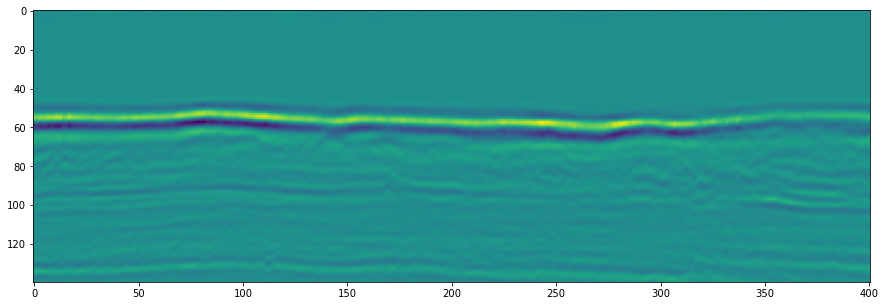

In [36]:
from bruges.filters import rotate_phase

s_ = rotate_phase(seismic, 60, degrees=True)

plt.figure(figsize=(15, 5))
plt.imshow(s_[:, :140].T, aspect='auto')

### EXERCISE

Make a slider to vary the phase and watch the amplitude change.

In [37]:
# YOUR CODE HERE



In [38]:
from bruges.filters import rotate_phase
from ipywidgets import interact

ma = np.percentile(seismic, 99.9)

@interact(phi=(-180, 180, 10))
def main(phi):
    s_ = rotate_phase(seismic, phi, degrees=True)
    plt.imshow(s_.T, aspect='auto', extent=(0, 400, 4.0, 0), vmin=-ma, vmax=ma)
    plt.plot(sf, c='r', lw=0.5)
    plt.ylim(0.5, 0)
    plt.show()
    return

interactive(children=(IntSlider(value=0, description='phi', max=180, min=-180, step=10), Output()), _dom_class…

In [39]:
# By the way, you can do this:
phis = np.arange(-180, 181, 1)
seismic_rot = rotate_phase(seismic, phi=phis, degrees=True)

seismic_rot.shape

(361, 401, 1003)

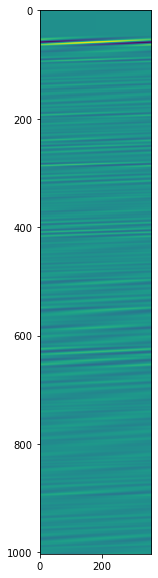

In [40]:
# Weird slices... One trace at all phases:
plt.figure(figsize=(2, 10))
plt.imshow(seismic_rot[:, 200].T, aspect='auto')

In [90]:
# This didn't really work
from bruges.filters import rotate_phase
from ipywidgets import interact

ma = np.percentile(seismic, 99.9)
seismic_rot = rotate_phase(seismic, phi=np.arange(-180, 181, 1), degrees=True)

@interact(phi=(-180, 180, 10))
def main(phi):
    s_rot = seismic_rot[phi+180]
    sf_rot = 0.004 * np.apply_along_axis(get_max_time, axis=1, arr=s_rot[:, :80])
    amp_rot = np.apply_along_axis(get_max_amp, axis=1, arr=s_rot[:, :80])
    
    fig, axs = plt.subplots(nrows=2, figsize=(15, 6), gridspec_kw={'height_ratios': [1, 1]})

    axs[0].plot(amp_rot)
    axs[0].set_ylim(0, 30000)
    axs[0].set_xlim(0, 400)
    axs[0].grid(color='k', alpha=0.2)
    
    axs[1].imshow(s_rot.T, aspect='auto', extent=(0, 400, 4.0, 0), vmin=-ma, vmax=ma)
    axs[1].plot(sf, c='yellow', lw=0.75)
    axs[1].plot(sf_rot, c='r', lw=0.5)
    axs[1].set_ylim(0.5, 0)

    plt.show()
    return

interactive(children=(IntSlider(value=0, description='phi', max=180, min=-180, step=10), Output()), _dom_class…

## Find zero phase

Method 4 from Roden & Sepulveda says that if we can find the phase with the greatest amplitude, this should be close to zero phase.

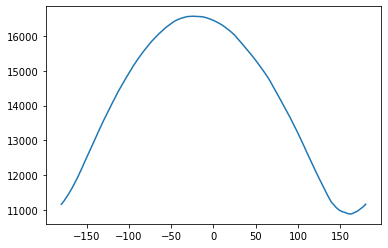

In [99]:
def rms(a):
    return np.sqrt(np.sum(a**2) / a.size)

amplitudes = []
for s_rot in seismic_rot:
    amp = np.apply_along_axis(get_max_amp, axis=1, arr=s_rot[:, :80])
    amplitudes.append(rms(amp))

plt.plot(phis, amplitudes)

In [100]:
import scipy.signal as ss

peak, _ = ss.find_peaks(amplitudes)

peak - 180

array([-25, -22, -14])

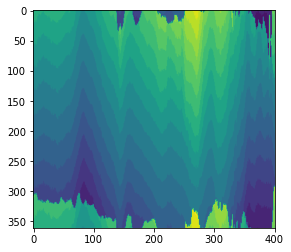

In [133]:
# Or we can detect our horizon in the full phase volume...
sfp_idx = np.argmax(seismic_rot[..., :80], axis=2)
sfp = sfp_idx * 0.0040

plt.imshow(sfp)

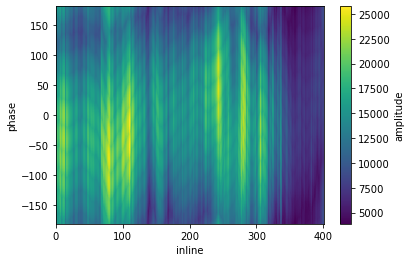

In [138]:
# Getting the amplitudes is a bit annoying, let's use xarray...
p = np.arange(-180, 181, 1)
seismic_rot_ = xr.DataArray(seismic_rot,
                            name='amplitude',
                            coords=[p, i, t*0.004],
                            dims=['phase', 'inline', 'twt']
                           )

sfp_ = xr.DataArray(sfp,
                    name='twt',
                    coords=[p, i],
                    dims=['phase', 'inline'],
                   )

sfpa = seismic_rot_.interp(twt=sfp_)

sfpa.plot()

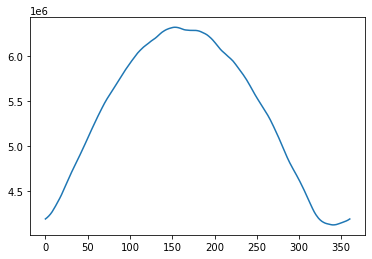

In [140]:
plt.plot(np.sum(sfpa, axis=1))

In [141]:
peak, _ = ss.find_peaks(np.sum(sfpa, axis=1))

peak - 180

array([-27,  -5])

It's a bit flaky, but you get the idea.

## Instantaneous phase

This is method number 3 from Roden and Sepulveda:

- Compute the envelope (this is the magnitude of the so-called 'complex trace' of Tury Taner: the real trace and the quadrature).
- Pick a strong, isolated, 'half-space' reflection on the envelope. 
- Compute the instantaneous phase _from the original seismic_ on that horizon.

So, first we need the envelope, then the phase.

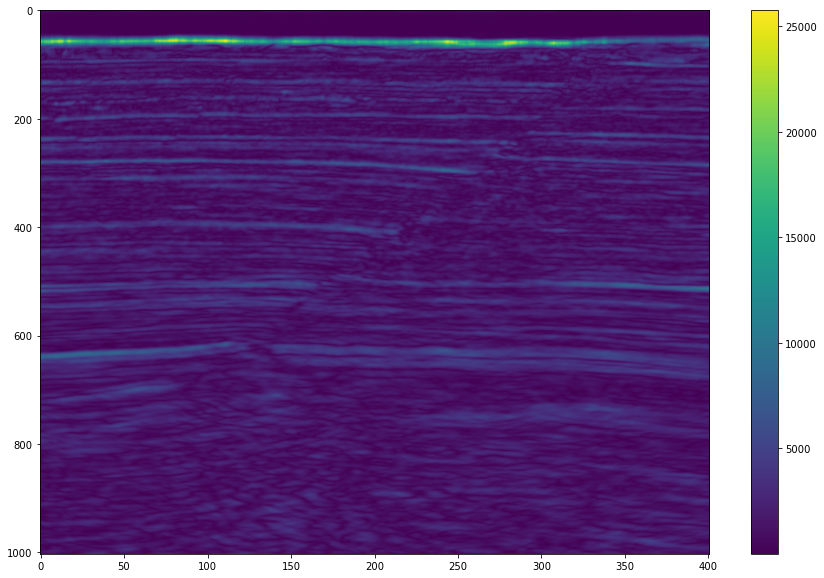

In [83]:
from scipy.signal import hilbert

h = hilbert(seismic)

env = np.abs(h)

plt.figure(figsize=(15, 10))
plt.imshow(env.T, aspect='auto')
plt.colorbar()

It looks kind of low-frequency, and it doesn't oscillate around zero like the seismic does.

Looking at a single trace is more instructive.

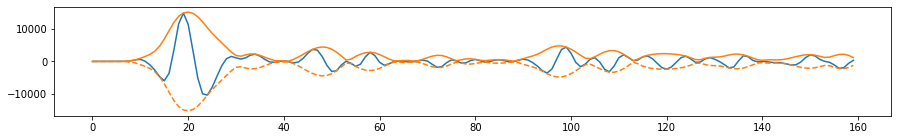

In [84]:
trace = 300

plt.figure(figsize=(15, 2))
plt.plot(seismic[trace, 40:200])
plt.plot(env[trace, 40:200])
plt.plot(-env[trace, 40:200], '--', c='C1')

### EXERCISE

Go on, add a slider to vary the phase.

In [85]:
@interact(phi=(-180, 180, 10), trace=(0, 401, 5))
def main(phi, trace):
    tr = seismic_rot[phi+180][trace]
    plt.figure(figsize=(15, 2))
    plt.plot(tr[40:200])
    plt.plot(env[trace, 40:200])
    plt.plot(-env[trace, 40:200], '--', c='C1')
    plt.show()
    return

interactive(children=(IntSlider(value=0, description='phi', max=180, min=-180, step=10), IntSlider(value=200, …

[Read more about the envelope.](https://agilescientific.com/blog/2011/3/23/e-is-for-envelope.html)

Now compute the instantanous phase. The phase $\phi$ is computed from the Hilbert transform $h$ by (adapted [from here](https://wiki.seg.org/wiki/Instantaneous_attributes)):

$$ \phi(t) = {\rm Im}[\ln h(t)] $$

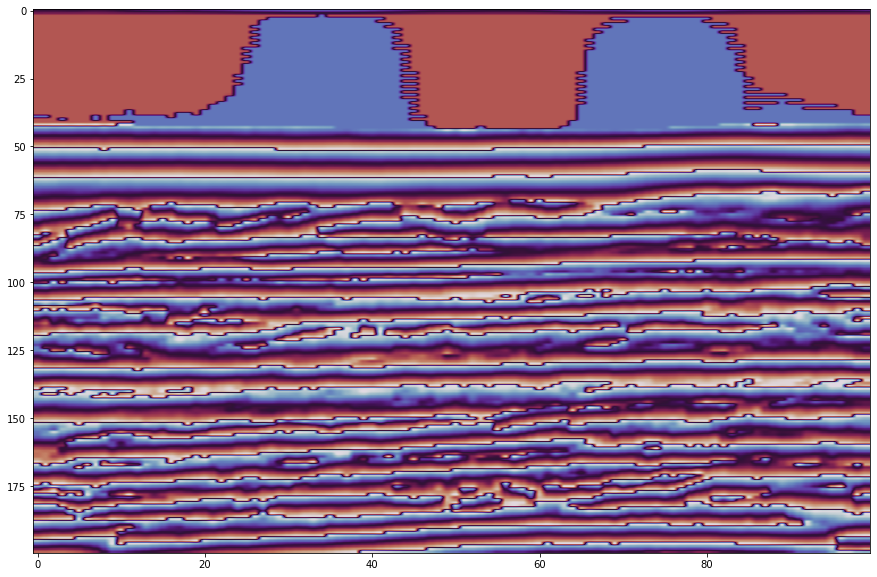

In [45]:
phi = np.log(h).imag

plt.figure(figsize=(15, 10))
plt.imshow(phi.T[:200, :100], cmap='twilight', aspect='auto')

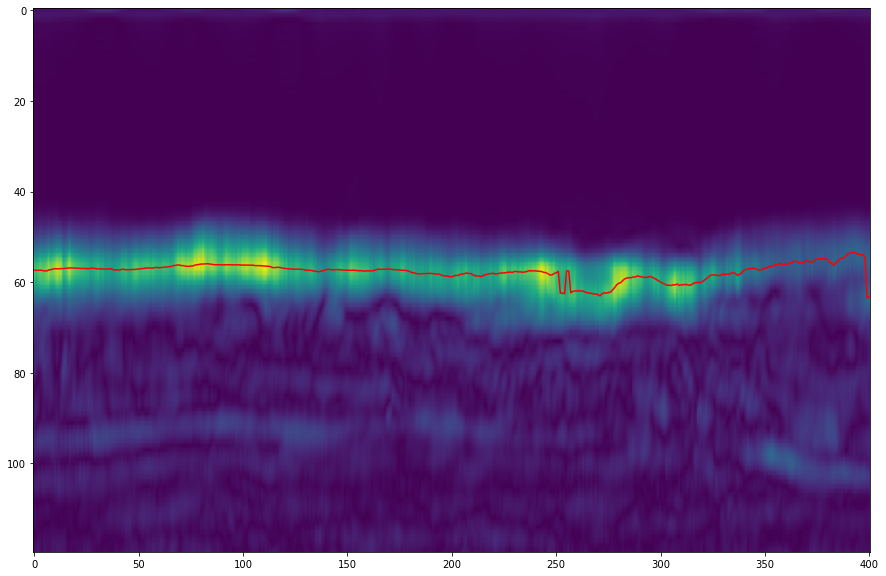

In [153]:
# Naive
# peak = np.argmax(env[:, :80], axis=-1)

peak = np.apply_along_axis(get_max_time, axis=1, arr=env[:, :80])

plt.figure(figsize=(15, 10))
plt.imshow(env[:, :120].T, aspect='auto')
plt.plot(peak, c='r')
plt.show()

We could compare the envelope pick to the trace pick &mdash; if they are the same then presumably the trace is zero-phase:

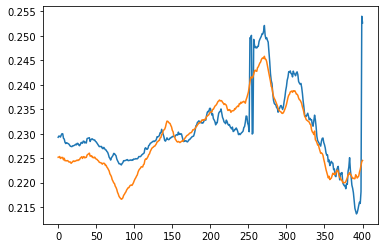

In [47]:
plt.plot(0.004 * peak)
plt.plot(sf)

Let's add a slider!

In [48]:
@interact(phi=(-180, 181, 10))
def plot(phi):
    sf_ = 0.004 * np.apply_along_axis(get_max_time, axis=1, arr=seismic_rot[phi+180, :, :80])
    plt.plot(0.004 * peak)
    plt.plot(sf_)
    plt.show()
    return

interactive(children=(IntSlider(value=0, description='phi', max=181, min=-180), Output()), _dom_classes=('widg…

Roden and Sepulveda recommend looking at the phase directly (units are radians):

In [49]:
phi.shape

(401, 1003)

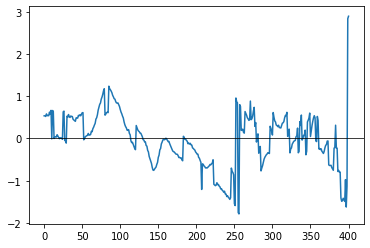

In [54]:
plt.plot(phi[np.arange(401), peak.astype(int)])
plt.axhline(0, lw=0.75, c='k')

The closer you look, the more complex it gets! Spatially varying phase is real.

## Maximum kurtosis

We can try implementing a methods from [Roy White's 1988 paper](https://academic.oup.com/gji/article/95/2/371/728307). He suggests a naive approach of phase rotate and measure kurtosis, and an analytic approach that saves having to do all the phase rotations. The naive approach is fine for our needs.

[Kurtosis](https://en.wikipedia.org/wiki/Kurtosis) is the 4th central moment of a dataset divided by the square of the variance... it's a measure of the length of the 'tailedness' of a distribution. We'll use the Pearson (as opposed to Fisher) convention, which scales such that Gaussian distributions have a kurtosis of 0.

In [142]:
seismic_rot.shape

(361, 401, 1003)

In [143]:
import scipy.stats as st

# The Pearson kurtosis has Gaussian = 0
kurtosis = st.kurtosis(seismic_rot.reshape(361, -1), axis=-1, fisher=False)
kurtosis.shape

(361,)

In [144]:
kurtosis.shape

(361,)

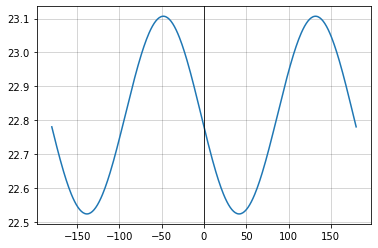

In [149]:
plt.plot(phis, kurtosis)
plt.axvline(0, c='k', lw=0.8)
plt.grid(c='k', alpha=0.2)

In [150]:
peaks, _ = ss.find_peaks(kurtosis)

phis[peaks]

array([-48, 132])

<hr />

<div>
<img src="https://avatars1.githubusercontent.com/u/1692321?s=50"><p style="text-align:center">© Agile Geoscience 2021</p>
</div>